# Black Box Variational Inference on Diagnostic Classification Models

$\textbf{Motivation behind ELBO cost function}$

The evidence lower bound is a lower bound of the log marginalized joint distribution $p(x, z)$. The value $\log p(x)$ is called the evidence.
$$\log p(x) = \log\left( \int p(x, z) dz\right)$$
$$ = \log \left(\int p(x, z)\frac{q(z)}{q(z)} dz\right)$$
$$ = \log \left(E_q\left[\frac{p(x, z)}{q(z)}\right]\right)$$
$$ \geq E_q[\log p(x, z)] - E_q[\log q(z)] \quad \text{(ELBO)}$$
The last term obtained via Jensen's inequality and linearity of expectation. It is referred to as the evidence lower bound. The ELBO shows up in variational inference as an alternative cost function to the KL divergence.
$$KL(q||p) = E_q\left[\log\left(\frac{q(z)}{p(z|x)}\right)\right]$$
$$ = E_q[\log q(z)] - E_q[\log p(z|x)]$$
$$ = E_q[\log q(z)] - E_q[\log p(x, z)] + E_q[\log p(x)]$$
$$ = -\text{ELBO} + \log p(x)$$
Since the goal of variational inference is to optimize the parameters of $q$, maximizing the ELBO with respect to $q$ is equivalent to minimizing the KL divergence with respect to $q$.

$\textbf{Noisy Gradient of the ELBO}$

The minimizer of the ELBO does not always have an analytical form. Instead, gradient ascent is used to find the maximizer. An unbiased estimator of the gradient is obtained by sampling from variational distirbution $q$.
The gradient of the ELBO is 
$$\nabla_{\lambda}L = E_q[\nabla_{\lambda}\log q(z|\lambda) (\log p(x, z) - \log q(z|\lambda))]$$
Assume each latent variable $z$ is governed by independent variational distributions such that $q(z|\lambda) = \prod_{i = 1}^n q(z_i|\lambda_i)$. Equation 5 from (Ranganath et. al., 2013) gives the Rao-Blackwellized estimator of the gradient for individual $\lambda_i$.
$$\nabla_{\lambda_i}L = E_{q_{(i)}}[\nabla_{\lambda_i}\log q(z_i|\lambda_i)(\log p_i(x, z_{(i)}) - \log q(z_i|\lambda_i))]$$
$E_{q_{(i)}}$ is the expectation with respect to the markov blanket of $z_i$, or the variables that depend on $z_i$, and $p_i(x, z_{(i)})$ is the terms of the join distribution that depend on $x$ and $z_i$.

$\textbf{Diagnostic Classification Model (DCM)}$

In this problem setting, there are $I$ items on an assesment, and each item measures up to $A$ attributes. Each latent class $c$ has an attribute profile $Z_c = [z_{c1}, ..., z_{cA}] \in \{0, 1\}^A$ where $z_{ca} = 0$ indicates that the $a$-th attribute is not mastered and $z_{ca} = 1$ indicates that the $a$-th attribute is mastered in latent class $c$. 

$Q \in \{0, 1\}^{I \times A}$ is called the Q matrix and $q_{ia}$ indicates whether question $i$ measures mastery of attribute $a$. 0 indicates that the attribute is not measured and 1 indicates that it is measured.

$\Delta_i = (\delta_{i1}, ..., \delta_{iL})^T$ is the feature matrix for item $i$, where each row is indexed by an attribute profile and the columns are the attributes and all the interactions of attributes measured by an item on the assesment. 1 indicates that the attributes in the interaction term are all mastered in the attributes profile. 0 indicates that at least 1 attribute in the interaction is not mastered in the attribute profile.

For example, consider that item $i$ measures mastery of 2 attributes. There are $L = 4$ possible attribute profiles (00, 01, 10, 11) corresponding to no masteries, mastering attribute 1, mastering attribute 2, and mastering both attributes. There are 4 features in $\Delta_i$ (00, 01, 10, 11) corresponding to intercept, main effect of attribute 1 mastery, main effect of attribute 2 mastery, and interaction effect.

$$
\begin{array}{ccccc} 
   & \textbf{00} & \textbf{01} & \textbf{10} & \textbf{11}\\
\textbf{00} & 1 & 0 & 0 & 0\\
\textbf{01} & 1 & 1 & 0 & 0\\
\textbf{10} & 1 & 0 & 1 & 0\\
\textbf{11} & 1 & 1 & 1 & 1
\end{array}
$$

The DCM models $\pi_{ic} = P(Y_{ic} = 1 | Z_c)$, the probability of a respondent with attribute profile $Z_c$ answering the $i$-th item correctly.

Let $\sigma$ be the sigmoid function, $\sigma(x) = \frac{1}{1 + e^{-x}}$
$$\pi_{ic} = \sigma(\beta_i^T\delta_{ic})$$
$$P(Y_{ic} = y_{ic} | Z_c) = (\pi_{ic})^{y_{ic}} \cdot (1 - \pi_{ic})^{1 - y_{ic}}$$
$$ = \sigma((2y_{ic} - 1)\beta_i^T\delta_{ic}) \quad \text{(Only true when $y_{ic} \in \{0, 1\}$)}$$

## Naive Black Box 

In this section black box variational inference will be used to estimate the parameters of a DCM model. Data is generated according to the probability model shown below. 

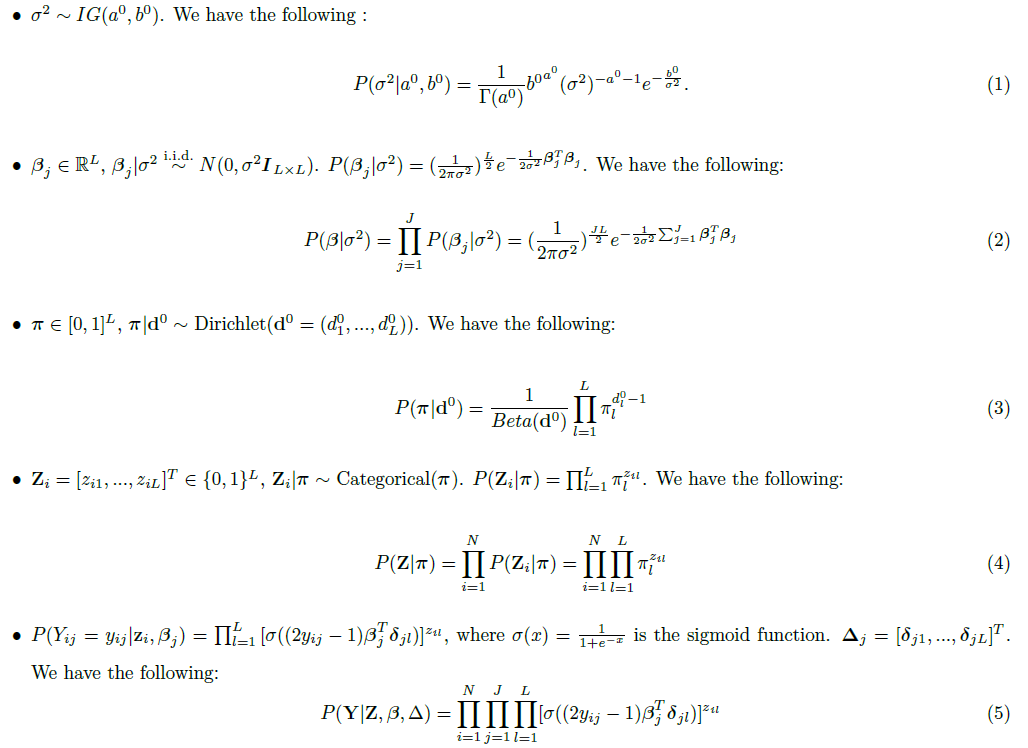

In [1]:
display("image/png", read("DCM probability model.png"))

The joint distribution is 
$$P(Y, Z, \beta, \pi, \sigma^2 | \Delta, d^0, a^0, b^0) = P(Y|Z,\beta,\Delta)P(Z|\pi)P(\pi|d^0)P(\beta|\sigma^2)P(\sigma^2|a^0,b^0)$$
$$ = \prod_{i = 1}^N\prod_{j = 1}^J\prod_{l = 1}^L [\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})]^{z_{il}} \cdot \prod_{i = 1}^N\prod_{l = 1}^L \pi_l^{z_{il}} \cdot \frac{1}{\text{Beta}(d^0)}\prod_{l = 1}^L \pi_l^{d^0_l - 1} \cdot \left(\frac{1}{2\pi\sigma^2}\right)^{\frac{JL}{2}}e^{-\frac{1}{2\sigma^2}\sum_{j = 1}^J\beta_j^T\beta_j} \cdot \frac{1}{\Gamma(a^0)}(b^0)^{a^0}(\sigma^2)^{-a^0 - 1}e^{-\frac{b^0}{\sigma^2}}$$

The variational distribution follows the mean field family
$$Q(Z, \beta, \pi, \sigma^2) = q_1(Z)q_2(\beta)q_3(\pi)q_4(\sigma^2)$$
$$ = \left(\prod_{i = 1}^Nq_{1i}(Z_i)\right)\left(\prod_{j = 1}^Jq_{2j}(\beta_j)\right)q_3(\pi)q_4(\sigma^2)$$
$$Z_i \sim \text{Categorical}(\pi_i^*) \quad \beta_j \sim N(\mu_j^*, V_j^*) \quad \pi \sim \text{Dirichlet}(d^*) \quad \sigma^2 \sim IG(a^*, b^*)$$

$\textbf{Noisy Gradient of }q_{1i}(Z_i)$

Since $q_{1i}$ is a categorical distribution, it can be parameterized by logits $\rho^*_{i} = \{\rho^*_{i1}, ..., \rho^*_{iL}\}$ such that $\pi^*_{il} = \frac{e^{\rho^*_{il}}}{\sum_{k = 1}^L e^{\rho^*_{ik}}}$ are obtained by the softmax transformation.

$$
\begin{aligned}
\log(q_{1i}(Z_i)) & = \sum_{l = 1}^{L}z_{il}\log(\pi_{il}^*)\\
\nabla_{\rho_{i}^*}\log(q_{1i}(Z_i)) & = Z_{i} - \pi_{i}^* \quad \text{(Equivalent to gradient of logit w.r.t cross entropy loss)}\\
\log(p(Y, Z_{(i)})) & = \sum_{j = 1}^J\sum_{l = 1}^Lz_{il}\log(\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})) + \sum_{l = 1}^Lz_{il}\log(\pi_l)
\end{aligned}
$$
Note that $\pi_l$ are latent variables in the probability model different from $\pi_{il}^*$ which are the parameters of the variational distribution. 

The gradient is approximated by sampling 

$$Z_{im} \sim q_{1i}(Z_i|\pi_i^*), \quad \beta_{jm} \sim q_{2j}(\beta_j|\mu_j^*, V_j^*), \quad \pi_m \sim q_4(\pi|d^*), \quad \text{for } m = 1, 2, ..., M$$

and taking the following average

$$
\begin{aligned}
\nabla_{\rho_{i}^*}L & = E_{q_{1i}(Z_i)}[\nabla_{\rho_{il}^*}\log(q_{1i}(Z_i))\cdot(\log(p(Y,Z_{(i)})) - \log(q_{1i}(Z_i)))]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[\left(Z_{im} - \pi_{il}^*\right)\cdot\left(\sum_{j = 1}^J\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl}))\right.\right.\\
 & \left.\left.+ \sum_{l = 1}^Lz_{iml}\log(\pi_{ml}) - \sum_{l = 1}^{L}z_{iml}\log(\pi_{il}^*)\right)\right]
\end{aligned}
$$

$\textbf{Noisy Gradient of }q_{2j}(\beta_j)$

To ensure that all gradient updates remain within the positive semi definite cone, let $V_j^* = C^*_jC^{*T}_j$ where $C^*_j$ is the lower triangular Cholesky factor of the Cholesky decomposition of $V_j^*$. We will update $C^*_j$ via noisy gradient descent. 

Let $k_j$ be the length of $\beta_j$ or the number of features.

$$
\begin{aligned}
\log(q_{2j}(\beta_j)) & = -\frac{k_j}{2}\log(2\pi) - \frac{1}{2}\log(|V_j^*|) - \frac{1}{2}(\beta_j - \mu_j^*)^T(V_j^*)^{-1}(\beta_j - \mu_j^*)\\
\nabla_{\mu_j^*}\log(q_{2j}(\beta_j)) & = (V_j^*)^{-1}(\beta_j - \mu_j^*)\\
\nabla_{V_j^*}\log(q_{2j}(\beta_j)) & = \frac{1}{2}(V_j^*)^{-1} - \frac{1}{2}(V_j^*)^{-1}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T(V_j^*)^{-1}\\
\frac{d\log(q_{2j}(\beta_j))}{d\text{ vech}(C^*_j)} & = \frac{d\log(q_{2j}(\beta_j))}{d\text{ vec}(V_j^*)} \cdot \frac{d\text{ vec}(V_j^*)}{d\text{ vech}(C^*_j)}\\
 & = \text{vec}\left(\nabla_{V_j^*}\log(q_{2j}(\beta_j))\right) \cdot \frac{d\text{ vec}(V_j^*)}{d\text{ vech}(C^*_j)}\\
 & = \text{vec}\left(\nabla_{V_j^*}\log(q_{2j}(\beta_j))\right) \cdot \left[C^*_j\otimes I + I\otimes C^*_j K_{k_j}\right]D_{k_j}\\
 & = \text{vec}\left(\frac{1}{2}(V_j^*)^{-1} - \frac{1}{2}(V_j^*)^{-1}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T(V_j^*)^{-1}\right) \cdot \left[C^*_j\otimes I + I\otimes C^*_j K_{k_j}\right]D_{k_j}\\
\log(p(Y, \beta_{(j)})) & = \sum_{i = 1}^N\sum_{l = 1}^Lz_{il}\log(\sigma((2y_{ij} - 1)\beta_j^T\delta_{jl})) - \frac{1}{2\sigma^2}\beta_j^T\beta_j
\end{aligned}
$$
**vec** and **vech** are the [vectorization](https://en.wikipedia.org/wiki/Vectorization_(mathematics)) and [half vectorization](https://en.wikipedia.org/wiki/Vectorization_(mathematics)#Half-vectorization) operations for matricies. $\otimes$ is the kronecker product. $K_{k_j}$ is the [commutation matrix](https://en.wikipedia.org/wiki/Commutation_matrix) for the vectorization of a $k_j$ by $k_j$ matrix. 

i.e. If $A \in R^{k_j \times k_j}$ then $K_{k_j}\text{vec}(A) = \text{vec}(A^T)$

$D_{k_j}$ is the duplication matrix for a lower triangular $k_j$ by $k_j$ matrix.

i.e. If $A$ is a lower triangular $k_j$ by $k_j$ matrix then $D_{k_j}\text{vech}(A) = \text{vec}(A)$ (Note: This is not the same as the duplication matrix for symmetric A)

The gradient is approximated by sampling
$$Z_{im} \sim q_{1i}(Z_i|\pi_i^*), \quad \beta_{jm} \sim q_{2j}(\beta_j|\mu_j^*, V_j^*), \quad \sigma_m \sim q_3(\sigma|a^*, b^*), \quad \text{for } m = 1, 2, ..., M$$

and taking the following averages

$$
\begin{aligned}
\nabla_{\mu_{j}^*}L & = E_{q_{2j}(\beta_j)}[\nabla_{\mu_{j}^*}\log(q_{2j}(\beta_j))\cdot(\log(p(Y,\beta_{(j)})) - \log(q_{2j}(\beta_j)))]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[(V_j^*)^{-1}(\beta_{jm} - \mu_j^*) \cdot \left(\sum_{i = 1}^N\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl})) - \frac{1}{2\sigma_m^2}\beta_{jm}^T\beta_{jm}\right.\right.\\
 & \left.\left.+ \frac{1}{2}\log(|V_j^*|) + \frac{1}{2}(\beta_{jm} - \mu_j^*)^T(V_j^*)^{-1}(\beta_{jm} - \mu_j^*)\right)\right]\\
\frac{dL}{d\text{ vech}(C_j)} & = E_{q_{2j}(\beta_j)}\left[\frac{d\log(q_{2j}(\beta_j))}{d\text{ vech}(C_j)}\cdot(\log(p(Y,\beta_{(j)})) - \log(q_{2j}(\beta_j)))\right]\\
 & \approx \frac{1}{M}\sum_{m = 1}^M\left[\text{vec}\left(\frac{1}{2}(V_j^*)^{-1} - \frac{1}{2}(V_j^*)^{-1}(\beta_j - \mu_j^*)(\beta_j - \mu_j^*)^T(V_j^*)^{-1}\right) \cdot \left[C_j\otimes I + I\otimes C_j K_{k_j}\right]D_{k_j}\right.\\ 
 & \left.\cdot \left(\sum_{i = 1}^N\sum_{l = 1}^Lz_{iml}\log(\sigma((2y_{ij} - 1)\beta_{jm}^T\delta_{jl})) - \frac{1}{2\sigma_m^2}\beta_{jm}^T\beta_{jm} + \frac{1}{2}\log(|V_j^*|) + \frac{1}{2}(\beta_{jm} - \mu_j^*)^T(V_j^*)^{-1}(\beta_{jm} - \mu_j^*)\right)\right]
\end{aligned}
$$

$\textbf{Noisy Gradient of }q_{3}(\pi)$


In [1]:
using LinearAlgebra
include("BBVI_modeling.jl")

In [2]:
using RCall

R"""
load("data.RData")
"""
data = @rget data
Y = data[:Y]
Q = convert(Matrix{Int64}, data[:Q])
obs = DCMObs(Y, Q);

In [3]:
a0 = 1e-2
b0 = 1e-4
d0 = ones(size(obs.D[1], 1))
M = 1000
model = DCModel(obs, d0, a0, b0, M);

**Initialize at optimal values**

In [4]:
pi_values = Dict("00"=>[.97, .01, .01, .01], 
                 "01"=>[.01, .97, .01, .01],
                 "10"=>[.01, .01, .97, .01],
                 "11"=>[.01, .01, .01, .97])
for i in 1:1000
    model.pi_star[i] .= pi_values[data[:skill][i]]
end

In [6]:
K = 10
for k in 1:K
    println("iter: $k")
    update_mu_star_V_star(model, step = 1e-3, maxiter = 30, verbose = true)
    update_d_star(model, step = 1e-3, maxiter = 20, verbose = false)
    update_a_star_b_star(model, step = 1e-5, maxiter = 30, verbose = true)
end

iter: 1
ELBO: -633.5823472266877
mu*_1: [-0.0990844512482, 0.3124608748706314, 0.5830082583635122, 0.3933590624559755]
gradient mu: [-672.6638573481168, 52.601941242073146, -46.96694119814265, 23.3997468951326]
C*_1: [0.02267816055126609 0.0 0.0 0.0; -0.12098800169728532 0.39057167304370277 0.0 0.0; 0.03921980811542582 -0.2455960413948778 0.443156029983928 0.0; 0.044874780509597076 -0.12827131278545273 -0.13162218879570245 0.792200894179935]
gradient C: [1263.2653032297567 0.0 0.0 0.0; 54.339479563656305 -110.28496538375185 0.0 0.0; 49.05314090804829 -73.07160929534817 -10.550088993070851 0.0; 25.43908579013391 -55.96710146618107 22.057924126706276 -47.97836850941856]
ELBO: -838.5295942157786
mu*_1: [-0.7717483085963168, 0.3650628161127045, 0.5360413171653695, 0.4167588093511081]
gradient mu: [119.96925499059536, 55.298830745893646, 77.76810045715884, 35.24694872961366]
C*_1: [1.2859434637810228 0.0 0.0 0.0; -0.06664852213362901 0.2802867076599509 0.0 0.0; 0.0882729490234741 -0.3186676

Excessive output truncated after 524337 bytes.


ELBO: -701.8265274216537
mu*_20: [0.13845334144251192, 0.15013939438722979]

In [8]:
model.mu_star

30-element Vector{Vector{Float64}}:
 [-0.4507791724291973, 0.5968321000669753, 1.0701848270003058, 0.6943134220654168]
 [-0.024375317169566847, 0.8058573070093756, 0.461712956383582, 0.75102593694654]
 [0.11169154984250718, 0.14280879253131717]
 [-0.060188975235069164, -0.06725849087356855]
 [-1.193388451173087]
 [0.19513848397173628, 0.015095075393895561]
 [-0.3097684628578901, 1.0041323656738745, 0.5896457625503242, 0.7093946749722174]
 [-0.12057782266426637, 0.6301191160861211, 0.5638241733921716, 0.5633973802431227]
 [-0.89971018251121]
 [0.22594445550509168, -0.03362779248290049]
 ⋮
 [0.03588936693644319, 0.12487271154557307]
 [0.14992093852940086, -0.02811676454734746]
 [-0.9506529018181564]
 [0.34767289742473617, 0.013521799726698376]
 [0.1875814829183755, -0.14306931621693575]
 [0.23151562601541653, -0.24898929388566363]
 [0.41181385587934793, -0.07923224999914158]
 [-1.0199787235850502]
 [-0.3631143869851612, 0.6169023546492682, 0.8100419118406028, 0.663977762732499]

In [31]:
pred = []
for i in 1:1000
    push!(pred, argmax(model.pi_star[i]))
end

In [53]:
sum(pred .== 4)

31

In [50]:
sum(data[:skill] .== "11")

232

In [45]:
model.obs.D[2]

4×4 Matrix{Int64}:
 1  0  0  0
 1  1  0  0
 1  0  1  0
 1  1  1  1

In [44]:
model.obs.D[3]

4×2 Matrix{Int64}:
 1  0
 1  1
 1  0
 1  1

In [54]:
data[:beta]

30-element Vector{Any}:
   [-1.0908464698819444, 1.4969379037618638, 1.4836376605555415, 0.5467837428674103]
   [-1.085415811627172, 1.4696301169227808, 1.4857180385151878, 0.5013018082128838]
   [-1.0617003259481863, 2.9305335130542516]
   [-1.1269538402557373, 2.9325977156870064]
 -1.0885653140954674
   [-1.0998363556107507, 2.9376237776130436]
   [-1.1092285147402434, 1.5082388046896085, 1.480892906500958, 0.4980965640163049]
   [-1.056060520769097, 1.454604054824449, 1.5034861729713156, 0.49426607822533697]
 -1.059363453043625
   [-1.0618957618251443, 2.9326482232660056]
  ⋮
   [-1.1135568148689343, 3.0277511939406394]
   [-1.1467085672542452, 3.039238517684862]
 -1.0684435825329275
   [-1.0992577146505937, 2.9225185251794756]
   [-1.0593676698859782, 2.982667790632695]
   [-1.1026244212174787, 3.042742836009711]
   [-1.1258128789486364, 2.9599281255155803]
 -1.0795521178515628
   [-1.0728325051954015, 1.4513840340543538, 1.5051313953474164, 0.5152461190475152]